In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

spark = SparkSession.builder \
        .master('local[*]') \
        .appName('Basics') \
        .getOrCreate()

print(spark.version)

3.5.4


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### Assign home directory
home_dir = 'C:/Users/gyalm/OneDrive/Desktop/churn_prediction/churn_prediction'

In [5]:
# Define functions
# Import additional packages
import datetime
import csv
import yaml
import io
import dill as pickle
import os

def get_datetime():
    """Returns datetime for filename use.

    :return: datetime
    :rtype: string
    """
    stamp = datetime.datetime.now()
    datetime_name = f"{stamp.year:04}{stamp.month:02}{stamp.day:02}_{stamp.hour:02}{stamp.minute:02}"
    print(datetime_name)
    return datetime_name

print('Functions ready!')

Functions ready!


In [6]:
df_2018 = spark.read.csv(f"C:/Users/gyalm/OneDrive/Desktop/churn_prediction/churn_prediction/data/week2_data_for_student_lab.csv.gz", inferSchema=True, header=True)
df_2018.show(10)
df_2018.createOrReplaceTempView("df_2018_view")

+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|transaction_date|member_type|           member_id|gender|product|quantity|amount|  age|card_type|branch_name|region|category_name|
+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|      2018-04-01|     member|ff96777d-cfda-11e...|FEMALE|   3267|      16|  5100|30-35|  REGULAR|    E_Store|     3|  FROZEN FOOD|
|      2018-04-09|     member|00d89024-cfdb-11e...|FEMALE|   6748|       1|  1100|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-01|     member|00858b3b-cfdb-11e...|FEMALE|    420|       4|  5300|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-13|     member|001035ed-cfdb-11e...|FEMALE|   3178|      16|  5600|45-50|  REGULAR|    A_Store|     1|      GADGETS|
|      2018-04-15|     member|ff5fafeb-cfda-11e...|FEMALE|   2727|      19| 

In [5]:
# Check first 5 rows of data
spark.sql('''
SELECT
  *
FROM
  df_2018_view
LIMIT
  5
''').show()

+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|transaction_date|member_type|           member_id|gender|product|quantity|amount|  age|card_type|branch_name|region|category_name|
+----------------+-----------+--------------------+------+-------+--------+------+-----+---------+-----------+------+-------------+
|      2018-04-01|     member|ff96777d-cfda-11e...|FEMALE|   3267|      16|  5100|30-35|  REGULAR|    E_Store|     3|  FROZEN FOOD|
|      2018-04-09|     member|00d89024-cfdb-11e...|FEMALE|   6748|       1|  1100|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-01|     member|00858b3b-cfdb-11e...|FEMALE|    420|       4|  5300|55-60|  REGULAR|    A_Store|     1|          PET|
|      2018-04-13|     member|001035ed-cfdb-11e...|FEMALE|   3178|      16|  5600|45-50|  REGULAR|    A_Store|     1|      GADGETS|
|      2018-04-15|     member|ff5fafeb-cfda-11e...|FEMALE|   2727|      19| 

In [7]:
# Check partition dates
spark.sql('''
SELECT
   MIN(transaction_date)
  ,MAX(transaction_date)
FROM
  df_2018_view
''').show()

+---------------------+---------------------+
|min(transaction_date)|max(transaction_date)|
+---------------------+---------------------+
|           2018-01-01|           2018-08-10|
+---------------------+---------------------+



In [8]:
# Count transactions in August
spark.sql('''
SELECT
   COUNT(CASE WHEN transaction_date BETWEEN '2018-08-01' AND '2018-08-31' THEN 1 ELSE NULL END) AS aug_txns
FROM
  df_2018_view
''').show()

+--------+
|aug_txns|
+--------+
|   42902|
+--------+



In [9]:
# Check partition dates
spark.sql('''
SELECT
   COUNT(CASE WHEN transaction_date BETWEEN '2018-08-01' AND '2018-08-31' THEN member_id ELSE NULL END) AS cnt_member_id
   ,COUNT(DISTINCT CASE WHEN transaction_date BETWEEN '2018-08-01' AND '2018-08-31' THEN member_id ELSE NULL END) AS cntd_member_id
FROM
  df_2018_view
''').show()

+-------------+--------------+
|cnt_member_id|cntd_member_id|
+-------------+--------------+
|        42902|         23896|
+-------------+--------------+



In [10]:
# Count target definition
spark.sql('''
WITH
customer_base AS (
SELECT
  DISTINCT member_id
FROM
  df_2018_view
WHERE
  transaction_date BETWEEN '2018-08-01' AND '2018-08-31'
)
,customer_base_joined_with_past_3_months_txn AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.transaction_date
FROM
  customer_base AS a
LEFT JOIN
  df_2018_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-05-01' AND '2018-07-31'
)
,customer_base_with_aggregated_total_txns_per_month AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-05-01' AND '2018-07-31' THEN quantity ELSE 0 END) AS sum_quantity
  ,'2018-06-01' AS partition_month
FROM
  customer_base_joined_with_past_3_months_txn
GROUP BY
  member_id
)
,customers_with_target_definition AS (
SELECT
  *
  ,CASE
    WHEN sum_quantity = 0 THEN 1
    ELSE 0
    END AS target
FROM
  customer_base_with_aggregated_total_txns_per_month
)
,count_customers_with_target_definition AS (
SELECT
  target
  ,COUNT(member_id) AS cnt_member_id
  ,COUNT(DISTINCT member_id) AS cntd_member_id
FROM
  customers_with_target_definition
GROUP BY
  target
)


SELECT
  *
FROM
  count_customers_with_target_definition
''').show()

+------+-------------+--------------+
|target|cnt_member_id|cntd_member_id|
+------+-------------+--------------+
|     1|         8902|          8902|
|     0|        14994|         14994|
+------+-------------+--------------+



In [11]:
# Compute PCC
(8902/(8902+14994))**2 + (8902/(8902+14994))**2

0.2775586435316345

In [12]:
# Compute PCC * 1.25
((8902/(8902+14994))**2 + (8902/(8902+14994))**2) * 1.25

0.34694830441454316

In [14]:
# Show first 5 rows of features for modeling
spark.sql('''
WITH
customer_base AS (
SELECT
  DISTINCT member_id
FROM
  df_2018_view
WHERE
  transaction_date BETWEEN '2018-08-01' AND '2018-08-31'
)
,customer_base_joined_with_past_3_months_txn AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.transaction_date
FROM
  customer_base AS a
LEFT JOIN
  df_2018_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-05-01' AND '2018-07-31'
)
,customer_base_with_aggregated_total_txns_per_month AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-05-01' AND '2018-07-31' THEN quantity ELSE 0 END) AS sum_quantity
  ,'2018-06-01' AS partition_date
FROM
  customer_base_joined_with_past_3_months_txn
GROUP BY
  member_id
)
,customers_with_target_definition AS (
SELECT
  *
  ,CASE
    WHEN sum_quantity = 0 THEN 1
    ELSE 0
    END AS target
FROM
  customer_base_with_aggregated_total_txns_per_month
)
,count_customers_with_target_definition AS (
SELECT
  target
  ,COUNT(member_id) AS cnt_member_id
  ,COUNT(DISTINCT member_id) AS cntd_member_id
FROM
  customers_with_target_definition
GROUP BY
  target
)
,customers_joined_with_features AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.amount
  ,b.category_name
  ,b.transaction_date
FROM
  customers_with_target_definition AS a
LEFT JOIN
  df_2018_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-01-01' AND '2018-03-31'
)
,aggregated_categories AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('ACCESSORIES') THEN amount ELSE 0 END) AS sum_amount_accessories
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('APPLIANCES') THEN amount ELSE 0 END) AS sum_amount_appliances
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('CLEANERS') THEN amount ELSE 0 END) AS sum_amount_cleaners
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('CLOTHES') THEN amount ELSE 0 END) AS sum_amount_clothes
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('FOOD') THEN amount ELSE 0 END) AS sum_amount_food
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('FROZEN FOOD') THEN amount ELSE 0 END) AS sum_amount_frozen_food
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('GADGETS') THEN amount ELSE 0 END) AS sum_amount_gadgets
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('HARDWARE') THEN amount ELSE 0 END) AS sum_amount_hardware
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('PET') THEN amount ELSE 0 END) AS sum_amount_pet
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('SHOES') THEN amount ELSE 0 END) AS sum_amount_shoes

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' THEN amount ELSE 0 END) AS sum_amount_total
  ,AVG(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' THEN amount ELSE 0 END) AS avg_amount_total
  ,MIN(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' THEN amount ELSE 0 END) AS min_amount_total
  ,MAX(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' THEN amount ELSE 0 END) AS max_amount_total


FROM
  customers_joined_with_features
GROUP BY
  member_id
)
,customers_with_target_joined_with_features AS (
SELECT
  a.member_id
  ,a.target
  ,a.partition_date
  ,b.sum_amount_accessories
  ,b.sum_amount_appliances
  ,b.sum_amount_cleaners
  ,b.sum_amount_clothes
  ,b.sum_amount_food
  ,b.sum_amount_frozen_food
  ,b.sum_amount_gadgets
  ,b.sum_amount_hardware
  ,b.sum_amount_pet
  ,b.sum_amount_shoes
  ,b.sum_amount_total
  ,b.avg_amount_total
  ,b.min_amount_total
  ,b.max_amount_total
FROM
  customers_with_target_definition AS a
LEFT JOIN
  aggregated_categories AS b
ON
  a.member_id = b.member_id
)

SELECT
  *
FROM
  customers_with_target_joined_with_features LIMIT 5
  --count_customers_with_target_definition
''').show()

+--------------------+------+--------------+----------------------+---------------------+-------------------+------------------+---------------+----------------------+------------------+-------------------+--------------+----------------+----------------+----------------+----------------+----------------+
|           member_id|target|partition_date|sum_amount_accessories|sum_amount_appliances|sum_amount_cleaners|sum_amount_clothes|sum_amount_food|sum_amount_frozen_food|sum_amount_gadgets|sum_amount_hardware|sum_amount_pet|sum_amount_shoes|sum_amount_total|avg_amount_total|min_amount_total|max_amount_total|
+--------------------+------+--------------+----------------------+---------------------+-------------------+------------------+---------------+----------------------+------------------+-------------------+--------------+----------------+----------------+----------------+----------------+----------------+
|002480e8-cfdb-11e...|     0|    2018-06-01|                     0|            

In [15]:
# Create scoring ABT (analytics base table)
df_sabt = spark.sql('''
WITH
customer_base AS (
SELECT
  DISTINCT member_id
FROM
  df_2018_view
WHERE
  transaction_date BETWEEN '2018-08-01' AND '2018-08-31'
)
,customer_base_joined_with_past_3_months_txn AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.transaction_date
FROM
  customer_base AS a
LEFT JOIN
  df_2018_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-05-01' AND '2018-07-31'
)
,customer_base_with_aggregated_total_txns_per_month AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-05-01' AND '2018-07-31' THEN quantity ELSE 0 END) AS sum_quantity
  ,'2018-06-01' AS partition_date
FROM
  customer_base_joined_with_past_3_months_txn
GROUP BY
  member_id
)
,customers_with_target_definition AS (
SELECT
  *
  ,CASE
    WHEN sum_quantity = 0 THEN 1
    ELSE 0
    END AS target
FROM
  customer_base_with_aggregated_total_txns_per_month
)
,count_customers_with_target_definition AS (
SELECT
  target
  ,COUNT(member_id) AS cnt_member_id
  ,COUNT(DISTINCT member_id) AS cntd_member_id
FROM
  customers_with_target_definition
GROUP BY
  target
)
,customers_joined_with_features AS (
SELECT
  a.member_id
  ,b.quantity
  ,b.amount
  ,b.category_name
  ,b.transaction_date
FROM
  customers_with_target_definition AS a
LEFT JOIN
  df_2018_view AS b
ON
  a.member_id = b.member_id
AND
  b.transaction_date BETWEEN '2018-01-01' AND '2018-03-31'
)
,aggregated_categories AS (
SELECT
   member_id
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('ACCESSORIES') THEN amount ELSE 0 END) AS sum_amount_accessories
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('APPLIANCES') THEN amount ELSE 0 END) AS sum_amount_appliances
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('CLEANERS') THEN amount ELSE 0 END) AS sum_amount_cleaners
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('CLOTHES') THEN amount ELSE 0 END) AS sum_amount_clothes
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('FOOD') THEN amount ELSE 0 END) AS sum_amount_food
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('FROZEN FOOD') THEN amount ELSE 0 END) AS sum_amount_frozen_food
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('GADGETS') THEN amount ELSE 0 END) AS sum_amount_gadgets
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('HARDWARE') THEN amount ELSE 0 END) AS sum_amount_hardware
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('PET') THEN amount ELSE 0 END) AS sum_amount_pet
  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name IN ('SHOES') THEN amount ELSE 0 END) AS sum_amount_shoes

  ,SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' THEN amount ELSE 0 END) AS sum_amount_total
  ,AVG(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' THEN amount ELSE 0 END) AS avg_amount_total
  ,MIN(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' THEN amount ELSE 0 END) AS min_amount_total
  ,MAX(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' THEN amount ELSE 0 END) AS max_amount_total


FROM
  customers_joined_with_features
GROUP BY
  member_id
)
,customers_with_target_joined_with_features AS (
SELECT
  a.member_id
  ,a.target
  ,a.partition_date
  ,b.sum_amount_accessories
  ,b.sum_amount_appliances
  ,b.sum_amount_cleaners
  ,b.sum_amount_clothes
  ,b.sum_amount_food
  ,b.sum_amount_frozen_food
  ,b.sum_amount_gadgets
  ,b.sum_amount_hardware
  ,b.sum_amount_pet
  ,b.sum_amount_shoes
  ,b.sum_amount_total
  ,b.avg_amount_total
  ,b.min_amount_total
  ,b.max_amount_total
FROM
  customers_with_target_definition AS a
LEFT JOIN
  aggregated_categories AS b
ON
  a.member_id = b.member_id
)

SELECT
  *
FROM
  customers_with_target_joined_with_features LIMIT 5
  --count_customers_with_target_definition
''')
df_sabt.createOrReplaceTempView("df_sabt_view")

In [16]:
# Save modeling ABT as pandas
pdf_sabt = df_sabt.toPandas()
pdf_sabt.head()

,member_id,target,partition_date,sum_amount_accessories,sum_amount_appliances,sum_amount_cleaners,sum_amount_clothes,sum_amount_food,sum_amount_frozen_food,sum_amount_gadgets,sum_amount_hardware,sum_amount_pet,sum_amount_shoes,sum_amount_total,avg_amount_total,min_amount_total,max_amount_total
0,002480e8-cfdb-11eb-9951-d8f2ca37414f,0,2018-06-01,0,0,6400,0,0,0,0,0,5300,0,11700,1462.5,0,6400
1,00526ef8-cfdb-11eb-a944-d8f2ca37414f,1,2018-06-01,0,0,0,0,0,0,0,0,0,5700,5700,5700.0,5700,5700
2,008b7ec3-cfdb-11eb-8910-d8f2ca37414f,1,2018-06-01,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0
3,ff066615-cfda-11eb-b652-d8f2ca37414f,1,2018-06-01,6000,0,7100,0,0,1900,0,0,0,0,15000,2500.0,0,7100
4,ff71fe04-cfda-11eb-9c78-d8f2ca37414f,1,2018-06-01,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0


In [17]:
# Check column names in data
pdf_sabt.columns

Index(['member_id', 'target', 'partition_date', 'sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes',
       'sum_amount_total', 'avg_amount_total', 'min_amount_total',
       'max_amount_total'],
      dtype='object')

In [18]:
# Check summary statistics
pdf_sabt[['sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes',
       'avg_amount_total', 'min_amount_total', 'max_amount_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
sum_amount_accessories,5.0,1200.0,2683.281573,0.0,0.0,0.0,0.0,6000.0
sum_amount_appliances,5.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
sum_amount_cleaners,5.0,2700.0,3705.401463,0.0,0.0,0.0,6400.0,7100.0
sum_amount_clothes,5.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
sum_amount_food,5.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
sum_amount_frozen_food,5.0,380.0,849.705831,0.0,0.0,0.0,0.0,1900.0
sum_amount_gadgets,5.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
sum_amount_hardware,5.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
sum_amount_pet,5.0,1060.0,2370.232056,0.0,0.0,0.0,0.0,5300.0
sum_amount_shoes,5.0,1140.0,2549.117494,0.0,0.0,0.0,0.0,5700.0


In [19]:
# Check summary statistics per target definition
pdf_sabt.groupby(['target'])[['sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes',
       'avg_amount_total', 'min_amount_total', 'max_amount_total']].describe().T

target                             0            1
sum_amount_accessories count     1.0     4.000000
                       mean      0.0  1500.000000
                       std       NaN  3000.000000
                       min       0.0     0.000000
                       25%       0.0     0.000000
                       50%       0.0     0.000000
                       75%       0.0  1500.000000
                       max       0.0  6000.000000
sum_amount_appliances  count     1.0     4.000000
                       mean      0.0     0.000000
                       std       NaN     0.000000
                       min       0.0     0.000000
                       25%       0.0     0.000000
                       50%       0.0     0.000000
                       75%       0.0     0.000000
                       max       0.0     0.000000
sum_amount_cleaners    count     1.0     4.000000
                       mean   6400.0  1775.000000
                       std       NaN  3550.000000
                       min    6400.0     0.000000
                       25%    6400.0     0.000000
                       50%    6400.0     0.000000
                       75%    6400.0  1775.000000
                       max    6400.0  7100.000000
sum_amount_clothes     count     1.0     4.000000
                       mean      0.0     0.000000
                       std       NaN     0.000000
                       min       0.0     0.000000
                       25%       0.0     0.000000
                       50%       0.0     0.000000
                       75%       0.0     0.000000
                       max       0.0     0.000000
sum_amount_food        count     1.0     4.000000
                       mean      0.0     0.000000
                       std       NaN     0.000000
                       min       0.0     0.000000
                       25%       0.0     0.000000
                       50%       0.0     0.000000
                       75%       0.0     0.000000
                       max       0.0     0.000000
sum_amount_frozen_food count     1.0     4.000000
                       mean      0.0   475.000000
                       std       NaN   950.000000
                       min       0.0     0.000000
                       25%       0.0     0.000000
                       50%       0.0     0.000000
                       75%       0.0   475.000000
                       max       0.0  1900.000000
sum_amount_gadgets     count     1.0     4.000000
                       mean      0.0     0.000000
                       std       NaN     0.000000
                       min       0.0     0.000000
                       25%       0.0     0.000000
                       50%       0.0     0.000000
                       75%       0.0     0.000000
                       max       0.0     0.000000
sum_amount_hardware    count     1.0     4.000000
                       mean      0.0     0.000000
                       std       NaN     0.000000
                       min       0.0     0.000000
                       25%       0.0     0.000000
                       50%       0.0     0.000000
                       75%       0.0     0.000000
                       max       0.0     0.000000
sum_amount_pet         count     1.0     4.000000
                       mean   5300.0     0.000000
                       std       NaN     0.000000
                       min    5300.0     0.000000
                       25%    5300.0     0.000000
                       50%    5300.0     0.000000
                       75%    5300.0     0.000000
                       max    5300.0     0.000000
sum_amount_shoes       count     1.0     4.000000
                       mean      0.0  1425.000000
                       std       NaN  2850.000000
                       min       0.0     0.000000
                       25%       0.0     0.000000
                       50%       0.0     0.000000
                       75%       0.0  1425.000000


In [20]:
# Copy data for modeling
data = pdf_sabt[['target', 'sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes',
       'avg_amount_total', 'min_amount_total', 'max_amount_total'
       ]].copy()

In [ ]:
# Separate target variable and features
y_oot = data['target']
X_oot = data.drop(['target'], axis=1)

In [23]:
#### Retrieve model

model_name = 'churn_prediction_20250215_2243_aggregated_3_months'

with open(f'{home_dir}/models/{model_name}.pickle', 'rb') as f:
  loaded_pipeline = pickle.load(f)

print(f'Model {model_name} ready!')

Model churn_prediction_20250215_2243_aggregated_3_months ready!


Accuracy: 0.20
Precision: 0.00
Recall: 0.00

Confusion Matrix:
[[1 0]
 [4 0]]


c:\Python Software\Python3_12_2\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


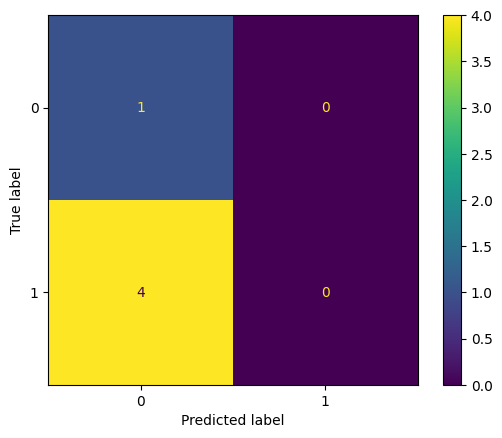

In [24]:
# Make predictions on the out of time dataset
y_pred_oot = loaded_pipeline.predict(X_oot)

# Evaluate the model
accuracy_oot = accuracy_score(y_oot, y_pred_oot)
precision_oot = precision_score(y_oot, y_pred_oot)
recall_oot = recall_score(y_oot, y_pred_oot)
cm_oot = confusion_matrix(y_oot, y_pred_oot)

print(f"Accuracy: {accuracy_oot:.2f}")
print(f"Precision: {precision_oot:.2f}")
print(f"Recall: {recall_oot:.2f}")
print(f"\nConfusion Matrix:")
print(cm_oot)

cmd_train = ConfusionMatrixDisplay(cm_oot)
cmd_train.plot()

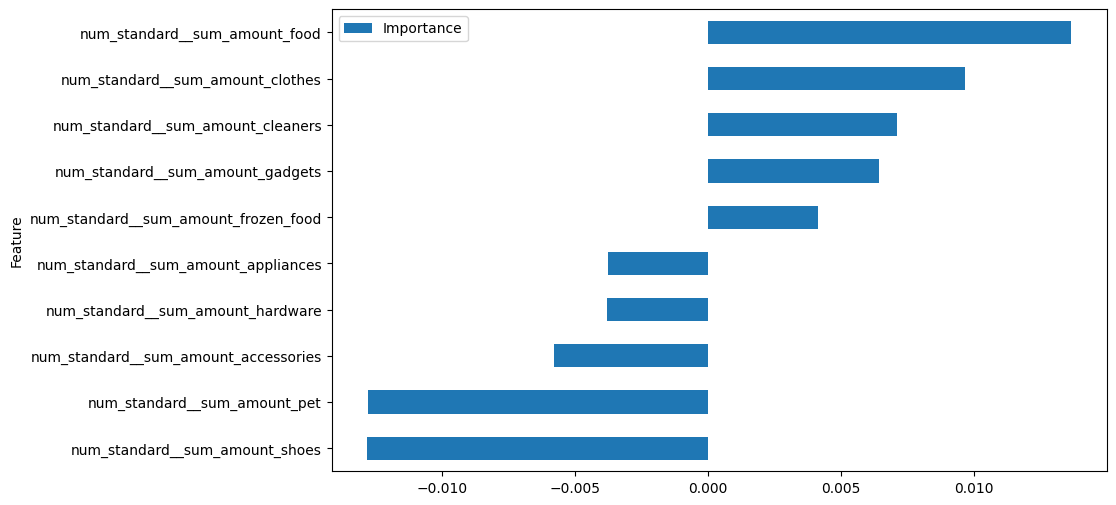

Intercept: -0.7882015726598848


In [25]:
#### Get coefficients & intercept

coefficients = loaded_pipeline.named_steps.estimator.coef_[0]
feature_names = loaded_pipeline.named_steps.preprocessor.get_feature_names_out()

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

intercept = loaded_pipeline.named_steps.estimator.intercept_[0]
print(f'Intercept: {intercept}')

In [13]:
spark.sql('''
WITH customer_base AS (
    SELECT DISTINCT member_id
    FROM df_2018_view
    WHERE transaction_date BETWEEN '2018-08-01' AND '2018-08-31'
),
customer_base_joined_with_past_3_months_txn AS (
    SELECT 
        a.member_id,
        b.quantity,
        b.transaction_date
    FROM customer_base AS a
    LEFT JOIN df_2018_view AS b
    ON a.member_id = b.member_id
    AND b.transaction_date BETWEEN '2018-05-01' AND '2018-07-31'
),
customer_base_with_aggregated_total_txns_per_month AS (
    SELECT 
        member_id,
        SUM(CASE 
            WHEN transaction_date BETWEEN '2018-05-01' AND '2018-07-31' THEN quantity 
            ELSE 0 
        END) AS sum_quantity,
        '2018-07-01' AS partition_date
    FROM customer_base_joined_with_past_3_months_txn
    GROUP BY member_id
),
customers_with_target_definition AS (
    SELECT 
        a.member_id,
        a.sum_quantity,
        a.partition_date,
        b.age,  
        b.branch_name, 
        CASE 
            WHEN a.sum_quantity = 0 THEN 1 
            ELSE 0 
        END AS target
    FROM customer_base_with_aggregated_total_txns_per_month AS a
    LEFT JOIN df_2018_view AS b
    ON a.member_id = b.member_id
),
customers_joined_with_features AS (
    SELECT 
        a.member_id,
        b.quantity,
        b.amount,
        b.age,
        b.branch_name,
        b.category_name,
        b.transaction_date
    FROM customers_with_target_definition AS a
    LEFT JOIN df_2018_view AS b
    ON a.member_id = b.member_id
    AND b.transaction_date BETWEEN '2018-02-01' AND '2018-04-30'
),
aggregated_categories AS (
    SELECT
       member_id,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'ACCESSORIES' THEN amount ELSE 0 END) AS sum_amount_accessories,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'APPLIANCES' THEN amount ELSE 0 END) AS sum_amount_appliances,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'CLEANERS' THEN amount ELSE 0 END) AS sum_amount_cleaners,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'CLOTHES' THEN amount ELSE 0 END) AS sum_amount_clothes,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'FOOD' THEN amount ELSE 0 END) AS sum_amount_food,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'FROZEN FOOD' THEN amount ELSE 0 END) AS sum_amount_frozen_food,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'GADGETS' THEN amount ELSE 0 END) AS sum_amount_gadgets,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'HARDWARE' THEN amount ELSE 0 END) AS sum_amount_hardware,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'PET' THEN amount ELSE 0 END) AS sum_amount_pet,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'SHOES' THEN amount ELSE 0 END) AS sum_amount_shoes
    FROM customers_joined_with_features
    GROUP BY member_id
),
count_customers_with_target_definition AS (
    SELECT 
        target,
        COUNT(member_id) AS cnt_member_id,
        COUNT(DISTINCT member_id) AS cntd_member_id
    FROM customers_with_target_definition
    GROUP BY target
)
SELECT * 
FROM count_customers_with_target_definition
''').show()

+------+-------------+--------------+
|target|cnt_member_id|cntd_member_id|
+------+-------------+--------------+
|     1|        34144|          8902|
|     0|        98940|         14994|
+------+-------------+--------------+



In [ ]:
# Compute PCC
(34144/(34144+98940))**2 + (8902/(8902+14994))**2

0.20460223568773755

In [15]:
# Compute PCC * 1.25
((34144/(34144+98940))**2 + (8902/(8902+14994))**2) * 1.25


0.25575279460967193

In [42]:
# Create scoring ABT (analytics base table)
df_sabt = spark.sql('''
WITH customer_base AS (
    SELECT DISTINCT member_id
    FROM df_2018_view
    WHERE transaction_date BETWEEN '2018-08-01' AND '2018-08-31'
),
customer_base_joined_with_past_3_months_txn AS (
    SELECT 
        a.member_id,
        b.quantity,
        b.transaction_date
    FROM customer_base AS a
    LEFT JOIN df_2018_view AS b
    ON a.member_id = b.member_id
    AND b.transaction_date BETWEEN '2018-05-01' AND '2018-07-31'
),
customer_base_with_aggregated_total_txns_per_month AS (
    SELECT 
        member_id,
        SUM(CASE 
            WHEN transaction_date BETWEEN '2018-05-01' AND '2018-07-31' THEN quantity 
            ELSE 0 
        END) AS sum_quantity,
        '2018-06-01' AS partition_date
    FROM customer_base_joined_with_past_3_months_txn
    GROUP BY member_id
),
customers_with_target_definition AS (
    SELECT 
        a.member_id,
        a.sum_quantity,
        a.partition_date,
        b.age,  
        b.branch_name, 
        CASE 
            WHEN a.sum_quantity = 0 THEN 1 
            ELSE 0 
        END AS target
    FROM customer_base_with_aggregated_total_txns_per_month AS a
    LEFT JOIN df_2018_view AS b
    ON a.member_id = b.member_id
),
customers_joined_with_features AS (
    SELECT 
        a.member_id,
        b.quantity,
        b.amount,
        b.age,
        b.branch_name,
        b.category_name,
        b.transaction_date
    FROM customers_with_target_definition AS a
    LEFT JOIN df_2018_view AS b
    ON a.member_id = b.member_id
    AND b.transaction_date BETWEEN '2018-01-01' AND '2018-03-31'
),
aggregated_categories AS (
    SELECT
       member_id,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'ACCESSORIES' THEN amount ELSE 0 END) AS sum_amount_accessories,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'APPLIANCES' THEN amount ELSE 0 END) AS sum_amount_appliances,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'CLEANERS' THEN amount ELSE 0 END) AS sum_amount_cleaners,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'CLOTHES' THEN amount ELSE 0 END) AS sum_amount_clothes,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'FOOD' THEN amount ELSE 0 END) AS sum_amount_food,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'FROZEN FOOD' THEN amount ELSE 0 END) AS sum_amount_frozen_food,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'GADGETS' THEN amount ELSE 0 END) AS sum_amount_gadgets,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'HARDWARE' THEN amount ELSE 0 END) AS sum_amount_hardware,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'PET' THEN amount ELSE 0 END) AS sum_amount_pet,
       SUM(CASE WHEN transaction_date BETWEEN '2018-02-01' AND '2018-04-30' AND category_name = 'SHOES' THEN amount ELSE 0 END) AS sum_amount_shoes
    FROM customers_joined_with_features
    GROUP BY member_id
),
customers_with_target_joined_with_features AS (
    SELECT 
        a.member_id,
        a.target,
        a.age,
        a.branch_name,
        b.sum_amount_accessories,
        b.sum_amount_appliances,
        b.sum_amount_cleaners,
        b.sum_amount_clothes,
        b.sum_amount_food,
        b.sum_amount_frozen_food,
        b.sum_amount_gadgets,
        b.sum_amount_hardware,
        b.sum_amount_pet,
        b.sum_amount_shoes,
        a.partition_date
    FROM customers_with_target_definition AS a
    LEFT JOIN aggregated_categories AS b
    ON a.member_id = b.member_id
)
SELECT * 
FROM customers_with_target_joined_with_features
''')
df_sabt.createOrReplaceTempView("df_sabt_view")

In [43]:
# Save modeling ABT as pandas
pdf_sabt = df_sabt.toPandas()
pdf_sabt.head()

,member_id,target,age,branch_name,sum_amount_accessories,sum_amount_appliances,sum_amount_cleaners,sum_amount_clothes,sum_amount_food,sum_amount_frozen_food,sum_amount_gadgets,sum_amount_hardware,sum_amount_pet,sum_amount_shoes,partition_date
0,00000871-cfdb-11eb-a068-d8f2ca37414f,1,35-40,E_Store,0,0,0,0,0,0,0,0,0,0,2018-06-01
1,00000871-cfdb-11eb-a068-d8f2ca37414f,1,35-40,A_Store,0,0,0,0,0,0,0,0,0,0,2018-06-01
2,00000871-cfdb-11eb-a068-d8f2ca37414f,1,35-40,A_Store,0,0,0,0,0,0,0,0,0,0,2018-06-01
3,00000871-cfdb-11eb-a068-d8f2ca37414f,1,35-40,B_Store,0,0,0,0,0,0,0,0,0,0,2018-06-01
4,00000871-cfdb-11eb-a068-d8f2ca37414f,1,35-40,A_Store,0,0,0,0,0,0,0,0,0,0,2018-06-01


In [44]:
pdf_sabt.groupby(['target'])[[
    'age', 'branch_name', 'sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes'
]].describe().T

target                                    0              1
sum_amount_accessories count   98940.000000   34144.000000
                       mean     5590.987467    4625.357310
                       std     22595.958303   16843.094396
                       min         0.000000       0.000000
                       25%         0.000000       0.000000
                       50%         0.000000       0.000000
                       75%         0.000000       0.000000
                       max    315200.000000  236600.000000
sum_amount_appliances  count   98940.000000   34144.000000
                       mean     5720.570042    5188.314199
                       std     22117.740162   18315.561358
                       min         0.000000       0.000000
                       25%         0.000000       0.000000
                       50%         0.000000       0.000000
                       75%         0.000000       0.000000
                       max    303800.000000  207900.000000
sum_amount_cleaners    count   98940.000000   34144.000000
                       mean    19944.829189   17309.325211
                       std     52347.454754   41656.636662
                       min         0.000000       0.000000
                       25%         0.000000       0.000000
                       50%         0.000000       0.000000
                       75%         0.000000   12500.000000
                       max    670400.000000  494400.000000
sum_amount_clothes     count   98940.000000   34144.000000
                       mean     6197.556095    4656.949977
                       std     23715.713507   16530.247775
                       min         0.000000       0.000000
                       25%         0.000000       0.000000
                       50%         0.000000       0.000000
                       75%         0.000000       0.000000
                       max    380800.000000  139700.000000
sum_amount_food        count   98940.000000   34144.000000
                       mean     5435.600364    3973.708411
                       std     21814.822199   15723.688789
                       min         0.000000       0.000000
                       25%         0.000000       0.000000
                       50%         0.000000       0.000000
                       75%         0.000000       0.000000
                       max    350200.000000  241000.000000
sum_amount_frozen_food count   98940.000000   34144.000000
                       mean     6155.235496    5307.986762
                       std     23979.572934   19566.962126
                       min         0.000000       0.000000
                       25%         0.000000       0.000000
                       50%         0.000000       0.000000
                       75%         0.000000       0.000000
                       max    415200.000000  215800.000000
sum_amount_gadgets     count   98940.000000   34144.000000
                       mean     5663.342430    4426.897844
                       std     22609.951327   16635.018756
                       min         0.000000       0.000000
                       25%         0.000000       0.000000
                       50%         0.000000       0.000000
                       75%         0.000000       0.000000
                       max    330400.000000  240500.000000
sum_amount_hardware    count   98940.000000   34144.000000
                       mean     5089.670507    4544.596415
                       std     20830.485978   16717.190908
                       min         0.000000       0.000000
                       25%         0.000000       0.000000
                       50%         0.000000       0.000000
                       75%         0.000000       0.000000
                       max    367200.000000  165000.000000
sum_amount_pet         count   98940.000000   34144.000000
                       mean    16106.089549   13254.123711
                       std     42801.555917   3

In [45]:
data = pdf_sabt[['target', 
    'age', 'branch_name', 'sum_amount_accessories',
       'sum_amount_appliances', 'sum_amount_cleaners', 'sum_amount_clothes',
       'sum_amount_food', 'sum_amount_frozen_food', 'sum_amount_gadgets',
       'sum_amount_hardware', 'sum_amount_pet', 'sum_amount_shoes'
]].copy()

In [46]:
# Separate target variable and features
y_oot = data['target']
X_oot = data.drop(['target'], axis=1)

In [47]:
#### Retrieve model

model_name = 'churn_prediction_20250215_2314_aggregated_3_months'

with open(f'{home_dir}/models/{model_name}.pickle', 'rb') as f:
  loaded_pipeline = pickle.load(f)

print(f'Model {model_name} ready!')

Model churn_prediction_20250215_2314_aggregated_3_months ready!


Accuracy: 0.7306
F1: 0.0165
Precision: 0.1297
Recall: 0.0088

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.98      0.84     98940
           1       0.13      0.01      0.02     34144

    accuracy                           0.73    133084
   macro avg       0.44      0.49      0.43    133084
weighted avg       0.58      0.73      0.63    133084

[[96927  2013]
 [33844   300]]


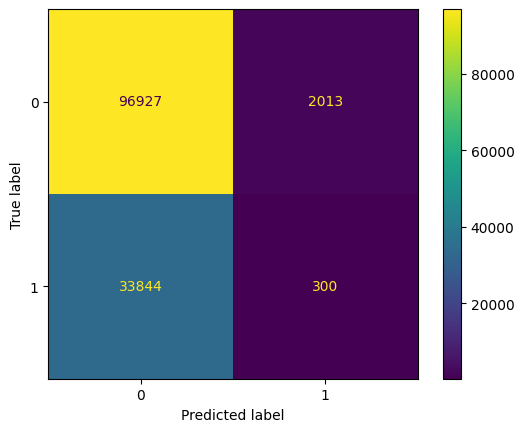

In [50]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, f1_score

# Make predictions on the out of time dataset
y_pred_oot = loaded_pipeline.predict(X_oot)

# Evaluate the model
print(f'Accuracy: {accuracy_score(y_oot, y_pred_oot):.4f}')
print(f'F1: {f1_score(y_oot, y_pred_oot):.4f}')
print(f'Precision: {precision_score(y_oot, y_pred_oot):.4f}')
print(f'Recall: {recall_score(y_oot, y_pred_oot):.4f}')

# Print classification report
print("\nClassification Report:")
print(classification_report(y_oot, y_pred_oot))

cm_train = confusion_matrix(y_oot, y_pred_oot)
print(cm_train)

cmd_train = ConfusionMatrixDisplay(cm_train)
cmd_train.plot()

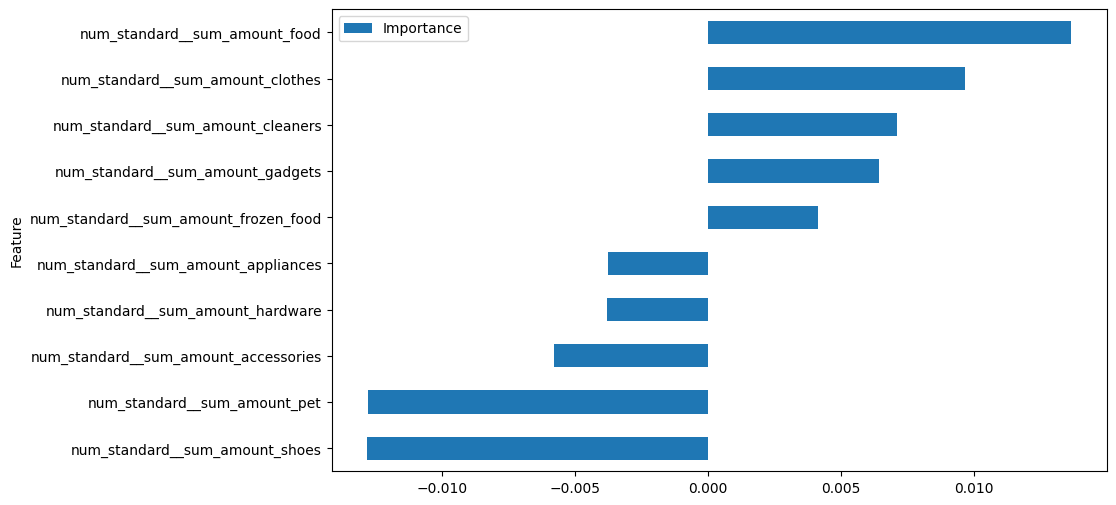

Intercept: -0.7882015726598848


In [51]:
#### Get coefficients & intercept

coefficients = loaded_pipeline.named_steps.estimator.coef_[0]
feature_names = loaded_pipeline.named_steps.preprocessor.get_feature_names_out()

feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.show()

intercept = loaded_pipeline.named_steps.estimator.intercept_[0]
print(f'Intercept: {intercept}')

Analysis of Week 7: Model Monitoring and Maintenance

In connection to Week 5: Machine Learning Model Evaluation, where the revised model deployed in Week 6: Model Deployment subsisted of using **CatBoostClassifier** instead of scikit-learn to leverage CatBoost’s native categorical handling and gradient boosting capabilities - the latter model, once extracted to predict based on the modified behavorial (May-July) and performance window (February-April) timelines, still showed improved predictive accuracy due to enhanced customer demographic features.

In the first iteration of the model, customer churn prediction relied solely on aggregated purchase categories within a behavioral window. However, this approach resulted in poor classification performance, as indicated by the initial evaluation metrics:  

- **Accuracy**: 0.20  
- **F1-score**: 0.00  
- **Precision & Recall**: 0.00 (suggesting the model failed to identify churned customers effectively)  

To improve predictive accuracy, the model was enhanced by incorporating additional customer demographic features, specifically **age range** and **most frequented branch**. These refinements led to a significant performance boost:  

- **Accuracy**: 0.7306  
- **F1-score**: 0.0165 
- **Precision**: 0.1297  
- **Recall**: 0.0088  

Comparatively, the PCC of the intial model is at **0.35**, whereas the latter model is at **0.26**. The initial model falls below the expected benchmarked performance, whereas the latter model surpasses the benchmarked performance in accuracy by approximately **.49**. Thus, despite the changes in the dataset, the latter model consistently performs better.